<a href="https://colab.research.google.com/github/varshareddykumbham/Speech-Emotion-Recognition-using-RNN-LSTM/blob/main/RNN_LSTM_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow==2.2

     |████████████████████████████████| 516.2MB 34kB/s 
     |████████████████████████████████| 460kB 50.1MB/s 
     |████████████████████████████████| 3.0MB 56.8MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [ ]:
!pip install soundfile

In [ ]:
%cd /content/drive/My Drive/Emotion_Recognition_Data

/content/drive/My Drive/Emotion_Recognition_Data


In [ ]:
from deep_emotion_recognition import DeepEmotionRecognizer
deeprec = DeepEmotionRecognizer(emotions=['angry', 'sad', 'neutral', 'ps', 'happy'], n_rnn_layers=2, n_dense_layers=2, rnn_units=128, dense_units=128)
deeprec.train()
print(deeprec.test_score())
prediction = deeprec.predict('data/validation/Actor_10/03-02-05-02-02-02-10_angry.wav')
print(f"Prediction: {prediction}")

[TESS&RAVDESS] There are 808 training audio files for category:angry
[TESS&RAVDESS] There are 147 testing audio files for category:angry
[TESS&RAVDESS] There are 812 training audio files for category:sad
[TESS&RAVDESS] There are 146 testing audio files for category:sad
[TESS&RAVDESS] There are 585 training audio files for category:neutral
[TESS&RAVDESS] There are 93 testing audio files for category:neutral
[TESS&RAVDESS] There are 513 training audio files for category:ps
[TESS&RAVDESS] There are 77 testing audio files for category:ps
[TESS&RAVDESS] There are 805 training audio files for category:happy
[TESS&RAVDESS] There are 147 testing audio files for category:happy
[+] Writed TESS & RAVDESS DB CSV File
[EMO-DB] Total files to write: 339
[EMO-DB] Training samples: 271
[EMO-DB] Testing samples: 67
[+] Writed EMO-DB CSV File
[Custom Dataset] There are 49 training audio files for category:neutral
[Custom Dataset] There are 33 testing audio files for category:neutral
[Custom Dataset] The

In [ ]:
import os
import sys
stderr = sys.stderr
sys.stderr = open(os.devnull, 'w')
import keras
sys.stderr = stderr
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=5,
                        inter_op_parallelism_threads=5, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 1,
                                        'GPU' : 0}
                       )


In [ ]:
from keras.layers import LSTM, GRU, Dense, Activation, LeakyReLU, Dropout
from keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import to_categorical

from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix,classification_report
import numpy as np
import seaborn as sns 

from data_extractor import load_data
from create_csv import write_custom_csv, write_emodb_csv, write_tess_ravdess_csv
from emotion_recognition import EmotionRecognizer
from utils import get_first_letters, AVAILABLE_EMOTIONS, extract_feature, get_dropout_str

import numpy as np
import pandas as pd
import random

In [ ]:
class DeepEmotionRecognizer(EmotionRecognizer):
    """
    The Deep Learning version of the Emotion Recognizer.
    This class uses RNN (LSTM, GRU, etc.) and Dense layers.
    #TODO add CNNs
    """
    def __init__(self, **kwargs):
        super().__init__(None, **kwargs)

        self.n_rnn_layers = kwargs.get("n_rnn_layers", 2)
        self.n_dense_layers = kwargs.get("n_dense_layers", 2)
        self.rnn_units = kwargs.get("rnn_units", 128)
        self.dense_units = kwargs.get("dense_units", 128)
        self.cell = kwargs.get("cell", LSTM)

        self.dropout = kwargs.get("dropout", 0.3)
        self.dropout = self.dropout if isinstance(self.dropout, list) else [self.dropout] * ( self.n_rnn_layers + self.n_dense_layers )
        self.output_dim = len(self.emotions)

        self.optimizer = kwargs.get("optimizer", "adam")
        self.loss = kwargs.get("loss", "categorical_crossentropy")

        self.batch_size = kwargs.get("batch_size", 64)
        self.epochs = kwargs.get("epochs", 1000)
        
        self.model_name = ""
        self._update_model_name()

        self.model = None

        self._compute_input_length()

        self.model_created = False

    def _update_model_name(self):
        emotions_str = get_first_letters(self.emotions)
        problem_type = 'c' if self.classification else 'r'
        dropout_str = get_dropout_str(self.dropout, n_layers=self.n_dense_layers + self.n_rnn_layers)
        self.model_name = f"{emotions_str}-{problem_type}-{self.cell.__name__}-layers-{self.n_rnn_layers}-{self.n_dense_layers}-units-{self.rnn_units}-{self.dense_units}-dropout-{dropout_str}.h5"

    def _get_model_filename(self):
        """Returns the relative path of this model name"""
        return f"results/{self.model_name}"

    def _model_exists(self):
        """
        Checks if model already exists in disk, returns the filename,
        and returns `None` otherwise.
        """
        filename = self._get_model_filename()
        return filename if os.path.isfile(filename) else None

    def _compute_input_length(self):
        """
        Calculates the input shape to be able to construct the model.
        """
        if not self.data_loaded:
            self.load_data()
        self.input_length = self.X_train[0].shape[1]

    def _verify_emotions(self):
        super()._verify_emotions()
        self.int2emotions = {i: e for i, e in enumerate(self.emotions)}
        self.emotions2int = {v: k for k, v in self.int2emotions.items()}

    def create_model(self):
        """
        Constructs the neural network based on parameters passed.
        """
        if self.model_created:
            # model already created, why call twice
            return

        if not self.data_loaded:
            # if data isn't loaded yet, load it
            self.load_data()
        
        model = Sequential()

        # rnn layers
        for i in range(self.n_rnn_layers):
            if i == 0:
                # first layer
                model.add(self.cell(self.rnn_units, return_sequences=True, input_shape=(None, self.input_length)))
                model.add(Dropout(self.dropout[i]))
            else:
                # middle layers
                model.add(self.cell(self.rnn_units, return_sequences=True))
                model.add(Dropout(self.dropout[i]))

        if self.n_rnn_layers == 0:
            i = 0

        # dense layers
        for j in range(self.n_dense_layers):
            # if n_rnn_layers = 0, only dense
            if self.n_rnn_layers == 0 and j == 0:
                model.add(Dense(self.dense_units, input_shape=(None, self.input_length)))
                model.add(Dropout(self.dropout[i+j]))
            else:
                model.add(Dense(self.dense_units))
                model.add(Dropout(self.dropout[i+j]))
                
        if self.classification:
            model.add(Dense(self.output_dim, activation="softmax"))
            model.compile(loss=self.loss, metrics=["accuracy"], optimizer=self.optimizer)
        else:
            model.add(Dense(1, activation="linear"))
            model.compile(loss="mean_squared_error", metrics=["mean_absolute_error"], optimizer=self.optimizer)
        
        self.model = model
        self.model_created = True
        if self.verbose > 0:
            print("[+] Model created")

    def load_data(self):
        """
        Loads and extracts features from the audio files for the db's specified.
        And then reshapes the data.
        """
        super().load_data()
        # reshape X's to 3 dims
        X_train_shape = self.X_train.shape
        X_test_shape = self.X_test.shape
        self.X_train = self.X_train.reshape((1, X_train_shape[0], X_train_shape[1]))
        self.X_test = self.X_test.reshape((1, X_test_shape[0], X_test_shape[1]))

        if self.classification:
            # one-hot encode when its classification
            self.y_train = to_categorical([ self.emotions2int[str(e)] for e in self.y_train ])
            self.y_test = to_categorical([ self.emotions2int[str(e)] for e in self.y_test ])
        
        # reshape labels
        y_train_shape = self.y_train.shape
        y_test_shape = self.y_test.shape
        if self.classification:
            self.y_train = self.y_train.reshape((1, y_train_shape[0], y_train_shape[1]))    
            self.y_test = self.y_test.reshape((1, y_test_shape[0], y_test_shape[1]))
        else:
            self.y_train = self.y_train.reshape((1, y_train_shape[0], 1))
            self.y_test = self.y_test.reshape((1, y_test_shape[0], 1))

    def train(self, override=False):
        if not self.model_created:
            self.create_model()

        if not override:
            model_name = self._model_exists()
            if model_name:
                self.model.load_weights(model_name)
                self.model_trained = True
                if self.verbose > 0:
                    print("[*] Model weights loaded")
                return
        
        if not os.path.isdir("results"):
            os.mkdir("results")

        if not os.path.isdir("logs"):
            os.mkdir("logs")

        model_filename = self._get_model_filename()

        self.checkpointer = ModelCheckpoint(model_filename, save_best_only=True, verbose=1)
        self.tensorboard = TensorBoard(log_dir=f"logs/{self.model_name}")

        self.history = self.model.fit(self.X_train, self.y_train,
                        batch_size=self.batch_size,
                        epochs=self.epochs,
                        validation_data=(self.X_test, self.y_test),
                        callbacks=[self.checkpointer, self.tensorboard],
                        verbose=self.verbose)
        
        self.model_trained = True
        if self.verbose > 0:
            print("[+] Model trained")

    def predict(self, audio_path):
        feature = extract_feature(audio_path, **self.audio_config).reshape((1, 1, self.input_length))
        if self.classification:
            return self.int2emotions[self.model.predict_classes(feature)[0][0]]
        else:
            return self.model.predict(feature)[0][0][0]

    def predict_proba(self, audio_path):
        if self.classification:
            feature = extract_feature(audio_path, **self.audio_config).reshape((1, 1, self.input_length))
            proba = self.model.predict(feature)[0][0]
            result = {}
            for prob, emotion in zip(proba, self.emotions):
                result[emotion] = prob
            return result
        else:
            raise NotImplementedError("Probability prediction doesn't make sense for regression")



    def test_score(self):
        y_test = self.y_test[0]
        if self.classification:
            y_pred = self.model.predict_classes(self.X_test)[0]
            y_test = [np.argmax(y, out=None, axis=None) for y in y_test]
            return accuracy_score(y_true=y_test, y_pred=y_pred)
        else:
            y_pred = self.model.predict(self.X_test)[0]
            return mean_absolute_error(y_true=y_test, y_pred=y_pred)

    def train_score(self):
        y_train = self.y_train[0]
        if self.classification:
            y_pred = self.model.predict_classes(self.X_train)[0]
            y_train = [np.argmax(y, out=None, axis=None) for y in y_train]
            return accuracy_score(y_true=y_train, y_pred=y_pred)
        else:
            y_pred = self.model.predict(self.X_train)[0]
            return mean_absolute_error(y_true=y_train, y_pred=y_pred)

    def confusion_matrix(self, percentage=True, labeled=True):
        """Compute confusion matrix to evaluate the test accuracy of the classification"""
        if not self.classification:
            raise NotImplementedError("Confusion matrix works only when it is a classification problem")
        y_pred = self.model.predict_classes(self.X_test)[0]
        # invert from keras.utils.to_categorical
        y_test = np.array([ np.argmax(y, axis=None, out=None) for y in self.y_test[0] ])
        print(classification_report(y_test,y_pred))
        matrix = confusion_matrix(y_test, y_pred, labels=[self.emotions2int[e] for e in self.emotions]).astype(np.float32)
        index = ['angry',  'happy', 'neutral', 'sad', 'surprised']  
        columns = ['angry',  'happy', 'neutral', 'sad', 'surprised']  
        cm_df = pd.DataFrame(matrix, index, columns)                      
        plt.figure(figsize=(10,6))  
        sns.heatmap(cm_df, annot=True)
        if percentage:
            for i in range(len(matrix)):
                matrix[i] = matrix[i] / np.sum(matrix[i])
            # make it percentage
            matrix *= 100
        if labeled:
            matrix = pd.DataFrame(matrix, index=[ f"true_{e}" for e in self.emotions ],
                                    columns=[ f"predicted_{e}" for e in self.emotions ])
        return matrix

    def n_emotions(self, emotion, partition):
        """Returns number of `emotion` data samples in a particular `partition`
        ('test' or 'train')
        """
        if partition == "test":
            if self.classification:
                y_test = np.array([ np.argmax(y, axis=None, out=None)+1 for y in np.squeeze(self.y_test) ]) 
            else:
                y_test = np.squeeze(self.y_test)
            return len([y for y in y_test if y == emotion])
        elif partition == "train":
            if self.classification:
                y_train = np.array([ np.argmax(y, axis=None, out=None)+1 for y in np.squeeze(self.y_train) ])
            else:
                y_train = np.squeeze(self.y_train)
            return len([y for y in y_train if y == emotion])

    def get_samples_by_class(self):
        """
        Returns a dataframe that contains the number of training 
        and testing samples for all emotions
        """
        train_samples = []
        test_samples = []
        total = []
        for emotion in self.emotions:
            n_train = self.n_emotions(self.emotions2int[emotion]+1, "train")
            n_test = self.n_emotions(self.emotions2int[emotion]+1, "test")
            train_samples.append(n_train)
            test_samples.append(n_test)
            total.append(n_train + n_test)
        
        # get total
        total.append(sum(train_samples) + sum(test_samples))
        train_samples.append(sum(train_samples))
        test_samples.append(sum(test_samples))
        return pd.DataFrame(data={"train": train_samples, "test": test_samples, "total": total}, index=self.emotions + ["total"])

    def get_random_emotion(self, emotion, partition="train"):
        """
        Returns random `emotion` data sample index on `partition`
        """
        if partition == "train":
            y_train = self.y_train[0]
            index = random.choice(list(range(len(y_train))))
            element = self.int2emotions[np.argmax(y_train[index])]
            while element != emotion:
                index = random.choice(list(range(len(y_train))))
                element = self.int2emotions[np.argmax(y_train[index])]
        elif partition == "test":
            y_test = self.y_test[0]
            index = random.choice(list(range(len(y_test))))
            element = self.int2emotions[np.argmax(y_test[index])]
            while element != emotion:
                index = random.choice(list(range(len(y_test))))
                element = self.int2emotions[np.argmax(y_test[index])]
        else:
            raise TypeError("Unknown partition, only 'train' or 'test' is accepted")

        return index

    def determine_best_model(self, train=True):
        # TODO
        raise TypeError("This method isn't supported yet for deep nn")

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

Test accuracy score: 89.48717948717949 %
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        78
           1       0.94      0.94      0.94        78
           2       0.97      0.86      0.91        78
           3       0.86      0.85      0.85        78
           4       0.88      0.87      0.88        78

    accuracy                           0.89       390
   macro avg       0.90      0.89      0.89       390
weighted avg       0.90      0.89      0.89       390

              predicted_angry  predicted_sad  ...  predicted_ps  predicted_happy
true_angry          96.153847       0.000000  ...      3.846154         0.000000
true_sad             0.000000      93.589745  ...      5.128205         0.000000
true_neutral         3.846154       6.410257  ...      2.564103         1.282051
true_ps              3.846154       0.000000  ...     84.615387        10.256411
true_happy          10.256411       0.000000  ...      2.564103  

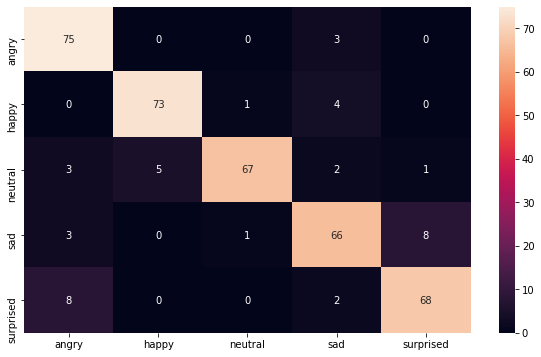

In [ ]:
if __name__ == "__main__":
    rec = DeepEmotionRecognizer(emotions=['angry', 'sad', 'neutral', 'ps', 'happy'],
                                epochs=300, verbose=0)
    rec.train(override=False)
    print("Test accuracy score:", rec.test_score() * 100, "%")
    print(rec.confusion_matrix())